In [1]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import random
from pycaret.classification import *
import os
import seaborn as sns; sns.set_theme(color_codes=True)

from torch import Tensor
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import  TensorDataset, DataLoader
import torchbnn as bnn
from scipy import stats

import pickle
import copy
import math
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score,accuracy_score,confusion_matrix,recall_score,precision_score,precision_recall_curve,f1_score,auc
from sklearn.preprocessing import minmax_scale
from sklearn.svm import SVC
from sklearn.metrics import r2_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import  mean_squared_error
import scipy.stats as ss
random_seed = 0
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

torch.cuda.set_device(3)
os.environ['CUDA_VISIBLE_DEVICES']='3'

In [2]:
ANM1 = pd.read_csv('/ANM1_inter_norm.csv',sep=',',index_col=0)
ANM2 = pd.read_csv('/ANM2_inter_norm.csv',sep=',',index_col=0)
ADNI = pd.read_csv('/ADNI_inter_norm.csv',sep=',',index_col=0)
add1 = pd.read_csv('/EW_inter_norm.csv',sep=',',index_col=0)
ROS = pd.read_csv('/ROSMAP_inter_norm.csv',sep=',',index_col=0)

add1 = add1.loc[:,add1.loc['DX']!='MCI' ]
annot = add1.loc['DX'].replace('NL' ,0)
annot = annot.replace('AD' ,1)
ad_ge_EW = np.ravel(annot, order='F').astype('float32')
EW_SNP = add1.loc['APOE4']
EW_MMSE= add1.loc['MMSE']
EW_value = add1
EW_value.drop('APOE4',axis=0,inplace=True)
EW_value.drop('DX',axis=0,inplace=True)
EW_value.drop('MMSE',axis=0,inplace=True)

ADNI = ADNI.loc[:,ADNI.loc['DX']!='MCI' ]
ADNI = ADNI.dropna(axis=1)
annot = ADNI.loc['DX'].replace('NL' ,0)
annot = annot.replace('AD' ,1)
ad_ge_ADNI = np.ravel(annot, order='F').astype('float32')
ADNI_SNP = ADNI.loc['APOE4']
ADNI_MMSE= ADNI.loc['MMSE']               
ADNI.drop('DX',axis=0,inplace=True)
ADNI.drop('MMSE',axis=0,inplace=True)
ADNI.drop('APOE4',axis=0,inplace=True)
ADNI_value = ADNI

ANM1 = ANM1.loc[:,ANM1.loc['DX']!='MCI' ]
annot = ANM1.loc['DX'].replace('NL' ,0)
annot = annot.replace('AD' ,1)
ad_ge_ANM1 = np.ravel(annot, order='F').astype('float32')
ANM1_SNP = ANM1.loc['APOE4']
ANM1_MMSE= ANM1.loc['MMSE']
ANM1.drop('APOE4',axis=0,inplace=True)
ANM1.drop('MMSE',axis=0,inplace=True)
ANM1.drop('DX',axis=0,inplace=True)
ANM1_value = ANM1

ANM2 = ANM2.loc[:,ANM2.loc['DX']!='MCI' ]
annot = ANM2.loc['DX'].replace('NL' ,0)
annot = annot.replace('AD' ,1)
ad_ge_ANM2 = np.ravel(annot, order='F').astype('float32')
ANM2.drop('DX',axis=0,inplace=True)
ANM2.loc['AGE'] = pd.DataFrame(ANM2.loc['AGE']).fillna(pd.DataFrame(ANM2.loc['AGE']).astype('float').mean(axis=0)).T.loc['AGE']
ANM2_SNP = ANM2.loc['APOE4']
ANM2_MMSE= ANM2.loc['MMSE']
ANM2.drop('APOE4',axis=0,inplace=True)
ANM2.drop('MMSE',axis=0,inplace=True)
ANM2_value = ANM2

ROS = ROS.loc[:,ROS.loc['DX']!='MCI' ]
annot = ROS.loc['DX'].replace('NL' ,0)
annot = annot.replace('AD' ,1)

ad_ge_ROS = np.ravel(annot, order='F').astype('float32')
ROS_SNP = ROS.loc['APOE4']
ROS_MMSE= ROS.loc['MMSE']
ROS.drop('APOE4',axis=0,inplace=True)
ROS.drop('MMSE',axis=0,inplace=True)
ROS.drop('DX',axis=0,inplace=True)
ROS_value = ROS

In [3]:
y_label_train2 = np.concatenate([ad_ge_ADNI,ad_ge_ANM1,ad_ge_ANM2,ad_ge_ROS])
X_train =  np.concatenate([ADNI_value.T.values,ANM1_value.T.values,ANM2_value.T.values,ROS_value.T.values]).astype('float')
y_APOE4_train2 =np.concatenate([ADNI_SNP.values.reshape(-1,1),ANM1_SNP.values.reshape(-1,1),ANM2_SNP.values.reshape(-1,1), ROS_SNP.values.reshape(-1,1)])
y_MMSE_train2 =np.concatenate([ADNI_MMSE.values.reshape(-1,1),ANM1_MMSE.values.reshape(-1,1),ANM2_MMSE.values.reshape(-1,1), ROS_MMSE.values.reshape(-1,1)])

X_val  = EW_value.T.values.astype('float')
y_label_val2 = ad_ge_EW
y_APOE4_val2=  EW_SNP.values.astype('float').reshape(-1,1)
y_MMSE_val2=  EW_MMSE.values.astype('float').reshape(-1,1)

In [4]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.dense1 =nn.Sequential(nn.Linear(14040 , int(14040 *1/16)))
        self.dense2 =nn.Sequential(nn.Linear(int(14040 *1/16), int(14040 *1/64)))
        self.dense3 =nn.Sequential(nn.Linear(int(14040 *1/64),int(14040 *1/256)))
        self.dense4  =nn.Sequential(nn.Linear(int(14040 *1/256),int(14040 *1/1024)))
        self.dense5  =nn.Sequential(nn.Linear(int(14040 *1/1024),int(14040 *1/4096)))
        self.dense6 =nn.Sequential(nn.Linear(int(14040 *1/4096),1),nn.Sigmoid())

    def forward(self, X):
        X = self.dense1(X)
        X = self.dense2(X)
        X = self.dense3(X)
        X = self.dense4(X)        
        X = self.dense5(X)        
        se_predict = self.dense6(X)

        return se_predict

In [5]:
loss_list = []
MMSE_AUC = []
corr  = []
epo = []

y_MMSE_train2= minmax_scale(y_MMSE_train2)
y_MMSE_val2=minmax_scale(y_MMSE_val2)

learningRate =0.00005
weightDecay = 0.0001
num_epochs = 10000
a=0

X_train = torch.tensor(X_train, dtype=torch.float32).cuda()
X_val = torch.tensor(X_val, dtype=torch.float32).cuda()

y_label_train2 = torch.tensor(y_label_train2, dtype=torch.float32).cuda()
y_MMSE_train2 = torch.tensor(y_MMSE_train2, dtype=torch.float32).cuda()


ds = TensorDataset(X_train,y_MMSE_train2)
loader  = DataLoader(ds, batch_size=1,shuffle=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = DNN()
net = net.to(device)
optimizer = optim.SGD(net.parameters(), lr=learningRate, weight_decay=weightDecay)
loss_fn2 = nn.MSELoss()

for epoch in (range(num_epochs)):
    running_loss = 0.0
    for i, data in enumerate(loader, 0):
        xg,y1= data
        output1 = net.forward(xg)
        output1  = output1.squeeze()
        net.train()
        optimizer.zero_grad()
        loss =  loss_fn2(output1, y1) 
        loss.backward(retain_graph=True)
        optimizer.step()
    epoch = epoch+1


    if (epoch+1) % 100 == 0 :
        print ('Epoch [{}], Loss: {:.4f}'.format(epoch+1 ,loss_fn2(output1, y1)   ))
        test1 = net.forward(X_val.clone().detach())
        test1 = test1.cpu().detach().numpy()
        train1 = net.forward(X_train.clone().detach())
        train1 = train1.cpu().detach().numpy()
        model4 = SVC(gamma='auto', probability=True)
        model4 = model4.fit(train1 , y_label_train2.cpu().detach().numpy())

        print (" AUC %.3f" %(roc_auc_score(y_label_val2.reshape(-1),model4.predict_proba(test1)[:,1])))
        corr.append(stats.spearmanr(y_MMSE_val2, test1).correlation)
        loss_list.append(loss_fn2(output1, y1))
        MMSE_AUC.append(roc_auc_score(y_label_val2.reshape(-1),model4.predict_proba(test1)[:,1]))
        epo.append(epoch)

model4 = model4.fit(train1 , y_label_train2.cpu().detach().numpy())
pred = model4.predict_proba(test1)[:,1]
print ("Using GE  AUC %.3f" %(roc_auc_score(y_label_val2.reshape(-1),model4.predict_proba(test1)[:,1])))

model4 = model4.fit(y_APOE4_train2.reshape(-1,1) , y_label_train2.cpu().detach().numpy())
print ("Using APOE4  AUC %.3f" %(roc_auc_score(y_label_val2.reshape(-1),model4.predict_proba(y_APOE4_val2.reshape(-1,1))[:,1])))

print ("Ensemble AUC %.3f" %(roc_auc_score(y_label_val2.reshape(-1),list(ss.zscore(pred) + ss.zscore(model4.predict_proba(y_APOE4_val2)[:,1]).reshape(-1)))))


Epoch [100], Loss: 0.0312
 AUC 0.402
Epoch [200], Loss: 0.0066
 AUC 0.467
Epoch [300], Loss: 0.0124
 AUC 0.403
Epoch [400], Loss: 0.0163
 AUC 0.472
Epoch [500], Loss: 0.0064
 AUC 0.585
Epoch [600], Loss: 0.0175
 AUC 0.606
Epoch [700], Loss: 0.0206
 AUC 0.614
Epoch [800], Loss: 0.0128
 AUC 0.635
Epoch [900], Loss: 0.0008
 AUC 0.652
Epoch [1000], Loss: 0.0188
 AUC 0.681
Epoch [1100], Loss: 0.0134
 AUC 0.709
Epoch [1200], Loss: 0.0000
 AUC 0.724
Epoch [1300], Loss: 0.0001
 AUC 0.725
Epoch [1400], Loss: 0.0001
 AUC 0.728
Epoch [1500], Loss: 0.0010
 AUC 0.730
Epoch [1600], Loss: 0.0038
 AUC 0.731
Epoch [1700], Loss: 0.0001
 AUC 0.737
Epoch [1800], Loss: 0.0021
 AUC 0.739
Epoch [1900], Loss: 0.0003
 AUC 0.741
Epoch [2000], Loss: 0.0000
 AUC 0.742
Epoch [2100], Loss: 0.0001
 AUC 0.742
Epoch [2200], Loss: 0.0001
 AUC 0.743
Epoch [2300], Loss: 0.0007
 AUC 0.741
Epoch [2400], Loss: 0.0015
 AUC 0.741
Epoch [2500], Loss: 0.0001
 AUC 0.738
Epoch [2600], Loss: 0.0002
 AUC 0.741
Epoch [2700], Loss: 0

No handles with labels found to put in legend.


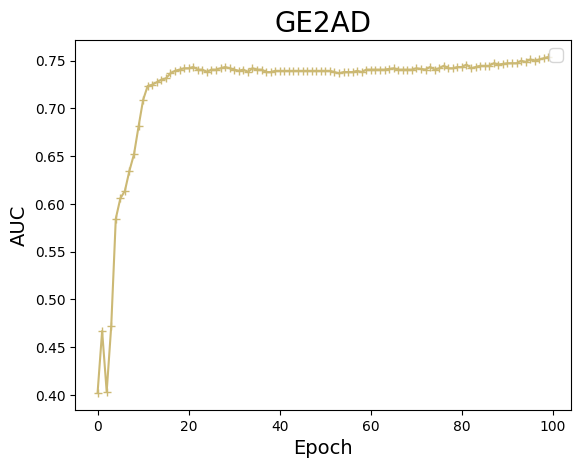

In [12]:
import matplotlib.pyplot as plt

import seaborn as sns
plt.style.use(['default'])
plt.plot(pd.DataFrame(MMSE_AUC), marker='+', color='y')

plt.title('GE2AD', fontsize=20) 

plt.ylabel('AUC', fontsize=14)

plt.xlabel('Epoch', fontsize=14)

plt.legend(fontsize=12, loc='best')

plt.show()

No handles with labels found to put in legend.


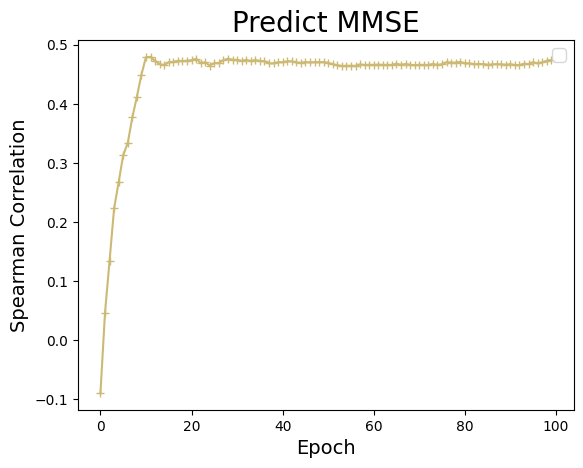

In [13]:
import matplotlib.pyplot as plt

import seaborn as sns
plt.style.use(['default'])
plt.plot(pd.DataFrame(corr), marker='+', color='y')

plt.title('Predict MMSE', fontsize=20) 

plt.ylabel('Spearman Correlation', fontsize=14)

plt.xlabel('Epoch', fontsize=14)

plt.legend(fontsize=12, loc='best')

plt.show()

No handles with labels found to put in legend.


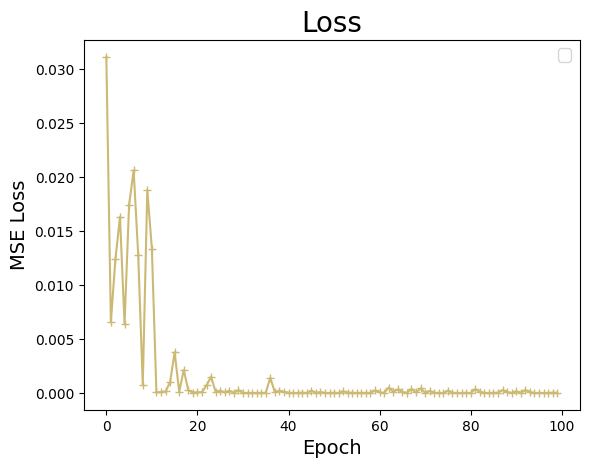

In [14]:
import matplotlib.pyplot as plt

import seaborn as sns
plt.style.use(['default'])
plt.plot(pd.DataFrame(loss_list), marker='+', color='y')

plt.title('Loss', fontsize=20) 

plt.ylabel('MSE Loss', fontsize=14)

plt.xlabel('Epoch', fontsize=14)

plt.legend(fontsize=12, loc='best')

plt.show()

In [ ]:
roc_auc_score(y_label_val2.reshape(-1),model4.predict_proba(test1)[:,1])